In [23]:
import numpy as np
import tensorflow as tf

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show
import lucid.misc.io.showing as showing
from lucid.misc.channel_reducer import ChannelReducer
import lucid.optvis.param as param
import lucid.optvis.objectives as objectives
import lucid.optvis.render as render
from lucid.misc.io import show, load
from lucid.misc.io.reading import read
from lucid.misc.io.showing import _image_url
import lucid.scratch.web.svelte as lucid_svelte
from lucid.misc.gradient_override import gradient_override_map

In [24]:
import sys
reload(sys)
sys.setdefaultencoding('utf-8')

In [25]:
model = models.InceptionResnet2()
model.load_graphdef()

In [26]:
labels_str = read("/home/elebouder/TNSRVIS/lucid/labelfile.txt")
labels = [line[line.find(" "):].strip() for line in labels_str.split("\n")]
labels = [label[label.find(" "):].strip().replace("_", " ") for label in labels]
labels = ["dummy"] + labels

In [27]:
%%html_define_svelte GroupWidget

<div class="figure" style="width: 600px;">
  <div class="outer" on:mouseover="set({pres_n: undefined})">
    <img src="{{img}}">
    {{#if pres_n != undefined}}
    <img src="{{spatial_factors[pres_n]}}" class="overlay"  >
    {{/if}}
  </div>
   
  <div class="outer" on:mouseover="set({pres_n: undefined})">
    <div style="width:100%; height: 100%; background-color: #000;"></div>
    {{#each range(n_groups) as n}}
    {{#if pres_n == undefined || pres_n == n}}
    <img src="{{spatial_factors[n]}}" class="factor" 
         style="filter: hue-rotate({{n*360/n_groups}}deg);">
    {{/if}}
    {{/each}}
  </div>
  
  <br>
  <br>
  
  <div on:mouseleave="set({pres_n: undefined})">
    {{#each range(n_groups) as n}}
    <div class="group" style="background-color: hsl({{n*360/n_groups}}, 80%, 50%); "
         on:mouseover="set({pres_n: n})">
      <img src="{{group_icons[n]}}">
    </div>
    {{/each}}
  </div>
  
</div>


<style>
  .outer{
    width: 224px;
    height: 224px;
    display: inline-block;
    margin-right: 2px;
    position: relative;
  }
  .outer img {
    position: absolute;
    left: 0px;
    top: 0px;
    width: 224px;
    height: 224px;
    image-rendering: pixelated; 
  }
  .factor {
    mix-blend-mode: lighten;
  }
  .overlay {
    filter: grayscale(100%) brightness(3);
    mix-blend-mode: multiply;
  }
  .group {
    width: 80px;
    height: 80px;
    margin-right: 4px;
    display: inline-block;
    padding-top: 10px;
  }
</style>

<script>
  function range(n){
    return Array(n).fill().map((_, i) => i);
  }
  
  export default {
    data () {
      return {
        img: "",
        n_groups: 1,
        spatial_factors: [""],
        group_icons: [""],
        pres_n: undefined,
        
      };
    },
    helpers: {range}
  };
</script>

In [31]:
def raw_class_group_attr(img, layer, label, group_vecs, override=None):
  """How much did spatial positions at a given layer effect a output class?"""

  # Set up a graph for doing attribution...
  with tf.Graph().as_default(), tf.Session(), gradient_override_map(override or {}):
    t_input = tf.placeholder_with_default(img, [None, None, 3])
    T = render.import_model(model, t_input, t_input)
    
    # Compute activations
    acts = T(layer).eval()
    
    if label is None: return np.zeros(acts.shape[1:-1])
    
    # Compute gradient
    #score = T("InceptionResnetV2/Logits/Predictions")[0, labels.index(label)]
    #score = T("softmax2_pre_activation")[0, labels.index(label)]
    t_grad = tf.gradients([score], [T(layer)])[0]   
    grad = t_grad.eval({T(layer) : acts})
    
    # Linear approximation of effect of spatial position
    return [np.sum(group_vec * grad) for group_vec in group_vecs]

In [32]:
def neuron_groups(img, layer, n_groups=6, attr_classes=[]):

  # Compute activations

  with tf.Graph().as_default(), tf.Session():
    t_input = tf.placeholder_with_default(img, [None, None, 3])
    T = render.import_model(model, t_input, t_input)
    acts = T(layer).eval()

  # We'll use ChannelReducer (a wrapper around scikit learn's factorization tools)
  # to apply Non-Negative Matrix factorization (NMF).

  nmf = ChannelReducer(n_groups, "NMF")
  spatial_factors = nmf.fit_transform(acts)[0].transpose(2, 0, 1).astype("float32")
  channel_factors = nmf._reducer.components_.astype("float32")

  # Let's organize the channels based on their horizontal position in the image

  x_peak = np.argmax(spatial_factors.max(1), 1)
  ns_sorted = np.argsort(x_peak)
  spatial_factors = spatial_factors[ns_sorted]
  channel_factors = channel_factors[ns_sorted]

  # And create a feature visualziation of each group

  param_f = lambda: param.image(80, batch=n_groups)
  obj = sum(objectives.direction(layer, channel_factors[i], batch=i)
            for i in range(n_groups))
  group_icons = render.render_vis(model, obj, param_f, verbose=False)[-1]
  
  # We'd also like to know about attribution
  
  # First, let's turn each group into a vector over activations
  group_vecs = [spatial_factors[i, ..., None]*channel_factors[i]
                for i in range(n_groups)]
  
  attrs = np.asarray([raw_class_group_attr(img, layer, attr_class, group_vecs)
                     for attr_class in attr_classes])
  
  print attrs
  
  # Let's render the visualization!
  
  lucid_svelte.GroupWidget({
    "img" : _image_url(img),
    "n_groups": n_groups,
    "spatial_factors": [_image_url(factor[..., None]/np.percentile(spatial_factors,99)*[1,0,0]) for factor in spatial_factors], 
    "group_icons": [_image_url(icon) for icon in group_icons] 
  })
  
  


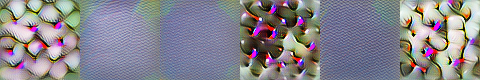

IndexError: list index out of range

In [37]:
img = load("/home/elebouder/Data/ChestXray-NIHCC/test.png")
neuron_groups(img, "InceptionResnetV2/Mixed_5b/concat", 6, ["Negative", "Positive"])

[]



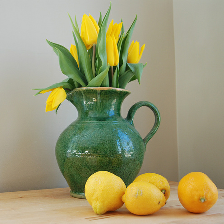
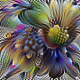
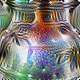
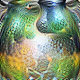
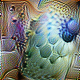
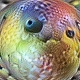

In [0]:
img = load("/home/elebouder/Data/ChestXray-NIHCC/test.png")
neuron_groups(img, "InceptionResnetV2/Mixed_6a/concat", 6, ["Negative", "Positive"])